In [ ]:
# Q2
# with training output 1 or 0 for si#lver particles without coalescence or with coalescence

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F

In [ ]:
class Dataset(Dataset):
    def __init__(self, root_dir, traj_dir):
        self.root_dir = root_dir
        self.traj_dir = traj_dir
   
        
    def __getitem__(self, idx):
        path = os.path.join(self.root_dir, self.traj_dir[idx])
        traj_path = os.listdir(path)
        
        traj_data = []
        for i in range(100):
            absolute_path = os.path.join(path, traj_path[i])
            data_i = np.load(absolute_path)
            traj_data.append(data_i)
        traj_data = torch.from_numpy(np.array(traj_data)).float()
        
        traj_label = []
        
            
        if 1 <= int(self.traj_dir[idx][1]) <= 23:
            traj_label.append(0)
        elif 24 <= int(self.traj_dir[idx][1]) <= 48:
            traj_label.append(1)
    
        traj_label = torch.from_numpy(np.array(traj_label)).float()
        
        return traj_data, traj_label
     
    def __len__(self):
        return len(self.traj_dir)
        
                                                                                                                                                                           

In [ ]:
root_dir = '/home/xh721/Documents/AIhackathon'
data1_16 = ['t'+str(x) for x in range(1, 16)]
data24_39 = ['t'+str(x) for x in range(24, 40)]

data16_23 = ['t'+str(x) for x in range(16, 24)]
data40_48 = ['t'+str(x) for x in range(40, 49)]

train_set =data1_16+data24_39
test_set = data16_23+data40_48
# print(train.shape)
# train=train.reshape(-1,1,31)
# test=test.reshape(-1,1,31)


In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

train = Dataset(root_dir, train_set)
test = Dataset(root_dir, test_set)


In [ ]:
# for data, label in train:
#     train_x =data
#     train_y = label
    
# for data, label in test:
#     test_x =data
#     test_y = label

In [7]:
# print(train_x.shape)

# print(train_y.shape)


In [8]:
batch_size = 5
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test,  batch_size=batch_size, shuffle=False)

In [9]:

class VAE(nn.Module):
    
    def __init__(self, inChannels=100, featureDim=1*10*10, zDim=1):
        super(VAE, self).__init__() # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(inChannels, 50, 24, stride= 20)
        self.encConv2 = nn.Conv2d(50, 1, 24, stride=3)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim) # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(1, 50, 24, stride=3)
        self.decConv2 = nn.ConvTranspose2d(50, 15, 24, stride= 20) 
    
    def encoder(self, x): # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 1*10*10)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar 
    
    def reparameterize(self, mu, logVar): 
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
    
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps 
    
    def decoder(self, z): # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 1, 10, 10)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x 
    
    def forward(self, x): # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar



In [10]:
lr = 0.001


x_dim  = 100
hidden_dim = 400
latent_dim = 200

num_epochs = 5


In [11]:
print("Start training VAE...")
from torch.optim import Adam

net=VAE()
all_loss = []
all_loss_list = []

optimizer = Adam(net.parameters(), lr=lr)
for epoch in range(num_epochs):
    net.train()
    loss1_all = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        out, mu, logVar = net(x)
        KL_divergence = - 0.5 * torch.sum(1+ logVar - mu.pow(2) - logVar.exp())
        loss1 = F.mse_loss(mu, y) + KL_divergence
        loss1_all += loss1.item()

        optimizer.zero_grad()
        loss1.backward()
        optimizer.step()

    all_loss.append(loss1_all)


    loss2_all = 0


    with torch.no_grad():
        net.eval()
    for batch_idx, (x, y) in enumerate(test_loader):
        pred, mu, logVar = net(x)
        KL_divergence = - 0.5 * torch.sum(1+ logVar - mu.pow(2) - logVar.exp())
        loss2 = F.mse_loss(mu, y) + KL_divergence
        loss2_all += loss2.item()

    all_loss_list.append(loss2_all)


    print('Epoch {}: Loss {}'.format(epoch, loss1_all))
    print('Epoch {}: Loss {}'.format(epoch, loss2_all))

Start training VAE...
Epoch 0: Loss 0.059687296161428094
Epoch 0: Loss 0.015402257209643722
Epoch 1: Loss 0.025418078992515802
Epoch 1: Loss 0.011574822361581028
Epoch 2: Loss 0.018489719019271433
Epoch 2: Loss 0.008012043312191963
Epoch 3: Loss 0.01256102355546318
Epoch 3: Loss 0.0052719078958034515
Epoch 4: Loss 0.008190517823095433
Epoch 4: Loss 0.0033818134397733957


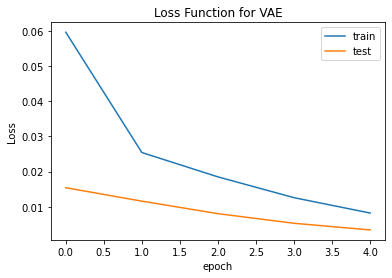

In [17]:

a=plt.figure()
plt.plot(all_loss, label='train')
plt.plot(all_loss_list, label = 'test')

plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss Function for VAE')
plt.legend()
plt.savefig('figure.png')